# Boston Airbnb Data Analysis

In [166]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns;sns.set()
from IPython.display import display

### Business questions

- What are the busiest times of the year to visit Boston? By how much do prices spike?
- Can we use other listing information to predict the housing price?
- The vibe of each Seattle neighborhood using listing descriptions?

## 1.Data Processing

###  1.1 Load the data

 - listings.csv: Summary information and metrics for listings in Boston (good for visualisations).
 - reviews.csv: Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).
 - neighbourhoods.csv: Neighbourhood list for geo filter. Sourced from city or open source GIS files.

In [35]:
df = pd.read_csv("./boston/calendar.csv") 
list_df = pd.read_csv("./boston/listings.csv")

### Question1: Seasonality of the price

In order to anaylize the trend of the housing price and identify when the busiest timing is, several steps are performed below:

- Cleaning the data for aggregation and visualization
- Visualize the time trend of the data
- Calculate by how much the price spikes and if there's some outliers

In [36]:
#convert the data of time and price and drop all of the na price, which is the unavailable housing
df['date'] = pd.to_datetime(df['date'])
df[['price']] = df[['price']].replace('[\$,]','',regex=True).astype(float)
df = df.dropna()
df.head()

,listing_id,date,available,price
365,3075044,2017-08-22,t,65.0
366,3075044,2017-08-21,t,65.0
367,3075044,2017-08-20,t,65.0
368,3075044,2017-08-19,t,75.0
369,3075044,2017-08-18,t,75.0


In [168]:
ax = sns.plot(x="date", y="price", data=price_df)

AttributeError: module 'seaborn' has no attribute 'plot'

In [157]:
price_df = df.groupby(['date'])['price'].mean().reset_index()

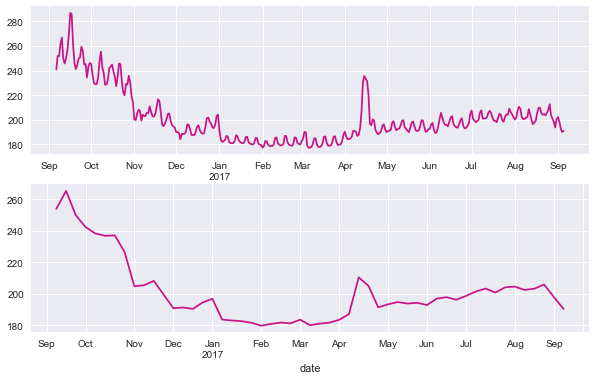

In [172]:
fig= plt.figure(figsize=(10,6))

price_df = df.groupby(['date'])['price'].mean()
plt.subplot(211)
price_df.resample('D').mean().plot(color='mediumvioletred')
plt.subplot(212)
price_df.resample('W').mean().plot(color='mediumvioletred')

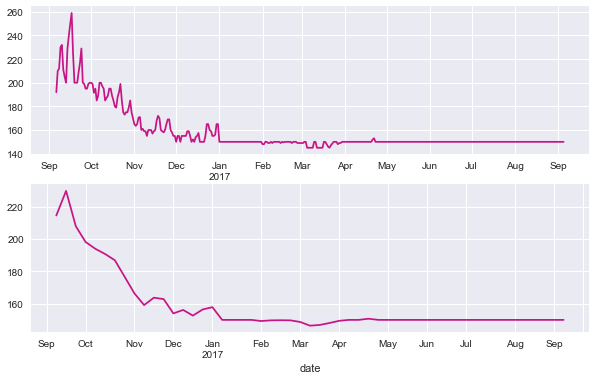

In [174]:
#Check robustness with median
fig= plt.figure(figsize=(10,6))
price_df = df.groupby(['date'])['price'].median()
plt.subplot(211)
price_df.resample('D').mean().plot(color='mediumvioletred')
plt.subplot(212)
price_df.resample('W').mean().plot(color='mediumvioletred')

### Conclusion
As we could see from the graph above, it seems that there are a spike of Boston is around fall and summer，which make sense since the winter boston is too cold for people to travel to.

### Question2: Predicting the listing price

Try to identify if we could build one machine learning model to help us predict the listing price:

- Cleaning both numerical and categorical variables
- Perform PCA Analysis and Try different models
- Tuning the parameter to select the best mod

In [39]:
# Take a look at the dataset
list_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


#### Keep Numeric Data

- Drop three unmeaningful data id, latitude, longitude
- Drop license and square_feet since over 90% of the data is null
- For the rest of the data, if there is null value, we fill it with mean in that column

In [41]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numlist = list_df.select_dtypes(include=numerics)
numlist.isna().sum()/numlist.shape[0]
droplist = ['scrape_id','host_id','latitude','longitude','license','square_feet']
#square_feet have 97% of the null value in the data
numlist = numlist.drop(droplist,axis=1)
numlist2 = numlist.fillna(numlist.mean())

In [42]:
numlist2.head()
numlist2.describe()

,id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,...,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,0.0,3585.000000,3585.000000
mean,8.440875e+06,58.902371,58.902371,NaN,3.041283,1.221647,1.255944,1.609060,1.429847,3.171269,...,91.916667,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,12.733891,1.970908
std,4.500787e+06,171.119663,171.119663,NaN,1.778929,0.500507,0.752008,1.010473,1.056787,8.874133,...,8.381157,0.817902,1.026947,0.669837,0.646143,0.793095,0.887785,NaN,29.415076,1.883678
min,3.353000e+03,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,20.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,1.000000,0.010000
25%,4.679319e+06,1.000000,1.000000,NaN,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,91.000000,9.000000,9.000000,9.646293,9.646549,9.000000,9.000000,NaN,1.000000,0.640000
50%,8.577620e+06,2.000000,2.000000,NaN,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,92.000000,9.431571,9.258041,10.000000,10.000000,9.414043,9.168234,NaN,2.000000,1.910000
75%,1.278953e+07,7.000000,7.000000,NaN,4.000000,1.000000,2.000000,2.000000,1.000000,3.000000,...,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,6.000000,2.130000
max,1.493346e+07,749.000000,749.000000,NaN,16.000000,6.000000,5.000000,16.000000,14.000000,300.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,136.000000,19.150000


#### Categorical Data

1. For the convenient of on-hot coding, drop some of the vairables. They are irrelevent, not useful or takes long time to transform and group them into useful feature
2. Some of the variables such as rate or price are supposed to be numeric but are stored as categorical. Convert them into numeric type.
3. For some of the na value, replace them with the mode of the columns
4. Finally, do one-hot encoding on all the selected categorical data, spreading them into seperate columns

In [43]:
category = ['object']
catlist = list_df.select_dtypes(include=category)

In [46]:
catlist2 = catlist.iloc[:,19:]
#square_feet have 97% of the null value in the data
catlist2 = catlist2.drop(catlist2.columns[catlist2.apply(lambda col: col.isnull().mean() > 0.4)], axis=1)
droplist = ['host_thumbnail_url','host_picture_url','city','state','country_code','country','calendar_last_scraped',
            'first_review','last_review','host_verifications','street','neighbourhood',
           'neighbourhood_cleansed','market','zipcode','smart_location','calendar_updated','amenities','host_neighbourhood',
           'cleaning_fee','extra_people']
#no idea how to deal with amenities
catlist3 = catlist2.drop(droplist,axis=1)

In [47]:
catlist3['host_response_rate'] = catlist3['host_response_rate'].str.rstrip('%').astype('float') / 100.0
catlist3['host_response_rate'] = catlist3['host_response_rate'].fillna(catlist3['host_response_rate'].mean())
catlist3['host_acceptance_rate'] = catlist3['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
catlist3['host_acceptance_rate'] = catlist3['host_acceptance_rate'].fillna(catlist3['host_acceptance_rate'].mean())
catlist3[['price']] = catlist3[['price']].replace('[\$,]','',regex=True).astype(float)

In [48]:
catlist3.head()

,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,property_type,room_type,bed_type,price,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,0.949891,0.841731,f,t,f,t,House,Entire home/apt,Real Bed,250.0,f,f,moderate,f,f
1,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,1.000000,1.000000,f,t,t,t,Apartment,Private room,Real Bed,65.0,f,t,moderate,f,f
2,2009-05-11,"Boston, Massachusetts, United States","I am a middle-aged, single male with a wide ra...",within a few hours,1.000000,0.880000,t,t,t,t,Apartment,Private room,Real Bed,65.0,f,f,moderate,t,f
3,2013-04-21,"Boston, Massachusetts, United States",My husband and I live on the property. He’s a...,within a few hours,1.000000,0.500000,f,t,f,f,House,Private room,Real Bed,75.0,f,f,moderate,f,f
4,2014-05-11,"Boston, Massachusetts, United States",I work full time for a public school district....,within an hour,1.000000,1.000000,t,t,t,t,House,Private room,Real Bed,79.0,f,f,flexible,f,f


In [49]:
listdata = pd.concat([numlist2, catlist3], axis=1,sort=False)

In [50]:
category = ['object']
catlist = listdata.select_dtypes(include=category)
numlist3 = listdata.select_dtypes(include=numerics)
catlist4 = catlist.apply(lambda col: col.fillna(col.mode()[0]),axis=1)
listdata2 = pd.concat([numlist3, catlist4], axis=1,sort=False)
listdata3 = pd.get_dummies(listdata2)

In [51]:
listdata3 = listdata3.drop('neighbourhood_group_cleansed',axis=1)

/Users/jinshuo/anaconda/envs/Python35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


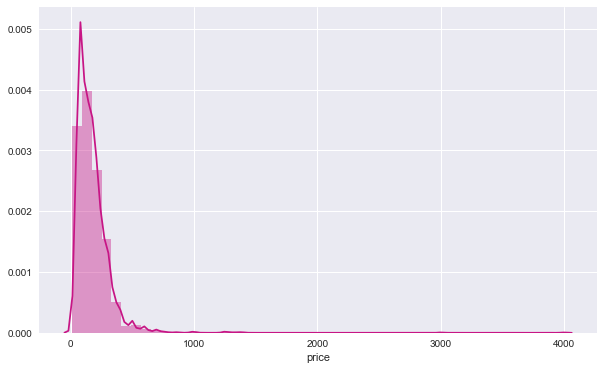

In [176]:
#take a look at the price distribution
#listdata3['price'].hist(bins=100)
fig= plt.figure(figsize=(10,6))
sns.distplot(listdata3['price'],color='mediumvioletred')

In [70]:
listdata3 = listdata3.drop(['has_availability','jurisdiction_names'],axis=1)

In [71]:
X = listdata3.drop(columns=['price','id'])
y = listdata3['price']
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

/Users/jinshuo/anaconda/envs/Python35/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jinshuo/anaconda/envs/Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


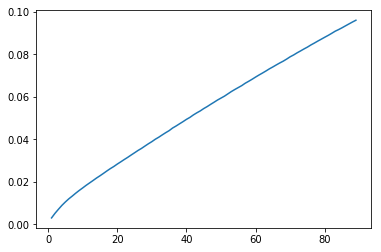

In [73]:
from sklearn.decomposition import PCA
explained_var = list()
for i in range(1,90):
    pca = PCA(n_components=i)
    pca.fit(rescaledX)
    explained_var.append(pca.explained_variance_ratio_.sum())
x = np.arange(1, 90)
expained_var = np.array(explained_var)
plt.plot(x,explained_var)

In [75]:
pca = PCA(n_components=42) 
pca.fit(rescaledX)
pcadata = pca.fit_transform(rescaledX)
pca.explained_variance_ratio_.sum()

0.051368934504677305

In [77]:
X_train, X_test, y_train, y_test = train_test_split(pcadata, y, test_size=0.25, random_state=42)
lnmodel = LinearRegression(normalize=True)
lnmodel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [78]:
y_test_pred = lnmodel.predict(X_test)
y_train_pred = lnmodel.predict(X_train)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 13048.213, test: 24793.988
R^2 train: 0.319, test: 0.187


In [79]:
#Write a function to report performance of the model
def model_perf(Xdata,component_low,component_high,model):
    mse_train = list()
    mse_test = list()
    r2_train = list()
    r2_test = list()
    for i in range(component_low,component_high):
        pca = PCA(n_components=i) 
        pca.fit(Xdata)
        pcadata = pca.fit_transform(Xdata)
        X_train, X_test, y_train, y_test = train_test_split(pcadata, y, test_size=0.25, random_state=42)
        model.fit(X_train,y_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))
    x = range(component_low,component_high)
    plt.plot(x,mse_train,color='black')
    plt.plot(x,mse_test,color='blue')
    plt.show()

In [83]:
# Fianl
pca = PCA(n_components=46) 
pca.fit(rescaledX)
pcadata = pca.fit_transform(rescaledX)
pca.explained_variance_ratio_.sum()
lassomodel = linear_model.Lasso(alpha=0.8)
lassomodel.fit(X_train, y_train)
y_train_pred = lassomodel.predict(X_train)
y_test_pred = lassomodel.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 13059.652, test: 24522.461
R^2 train: 0.318, test: 0.196


**Conclusion**

After we composed PCA analysis and tried different number of components on different models including linear regression, random forest and lasso regression, evluated bymse score, lasso-regression performs the best out of the three models and the result is more consistent.

Tuning this parameter, and set the alpha to be at 0.8, the final model reports that the mse on test set is 24522.461, and R-square is 0.196.

The model can be further improved by included some of the variables that I exclude in the analysis (I still need to learn how to process these data) or combine and contruct some of the new and more meaningful feature.

### Question3: Neighbourhood Vibe

Finally, we use the neighbourhood overview data to try get a taste of the vibe in each neighbourhood. Following steps are executed:

- Select top5 neighbourhood with most count of text for analysis
- Calculate the tf_idf and get the top5 words for each target neighbourhood
- Interpreting the result of the analysis

In [112]:
n = ['neighbourhood','neighborhood_overview']
neighbour = list_df[n]

In [113]:
top_5 = neighbour['neighbourhood'].value_counts()

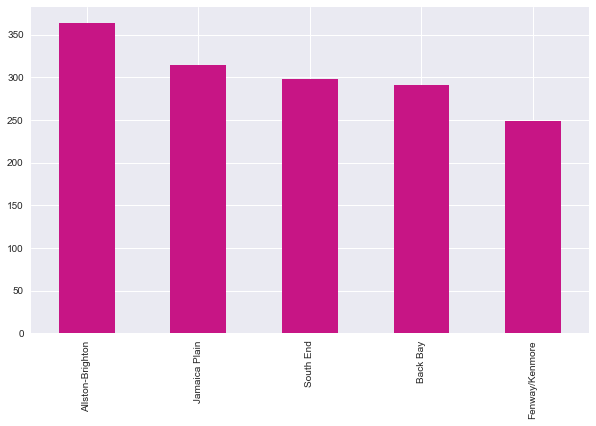

In [179]:
fig= plt.figure(figsize=(10,6))
top_5[:5].plot(kind='bar',color='mediumvioletred')

In [181]:
list(top_5[:5].index)

['Allston-Brighton',
 'Jamaica Plain',
 'South End',
 'Back Bay',
 'Fenway/Kenmore']

In [116]:
# We select the following 5 neighbourhood as target community for further analysis

neighbour = neighbour[neighbour.neighbourhood.isin(list(top_5[:5].index))]
neighbour['words'] = neighbour.neighborhood_overview.str.strip().str.split('[\W_]+')
neighbour.head()

/Users/jinshuo/anaconda/envs/Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,neighbourhood,neighborhood_overview,words
56,Jamaica Plain,NaN,NaN
57,Jamaica Plain,NaN,NaN
58,Jamaica Plain,NaN,NaN
59,Jamaica Plain,"The neighborhood is complete with all shops, r...","[The, neighborhood, is, complete, with, all, s..."
60,Jamaica Plain,Downtown Jamaica Plain is a delight with plent...,"[Downtown, Jamaica, Plain, is, a, delight, wit..."


In [117]:
n2 = neighbour.dropna(subset= ['words'])

In [118]:
rows = list()
for row in n2[['neighbourhood', 'words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((r.neighbourhood, word))

words = pd.DataFrame(rows, columns=['neighbourhood', 'word'])
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

,neighbourhood,word
0,Jamaica Plain,the
1,Jamaica Plain,neighborhood
2,Jamaica Plain,is
3,Jamaica Plain,complete
4,Jamaica Plain,with


In [119]:
counts = words.groupby('neighbourhood').word.value_counts().to_frame().rename(columns={'word':'n_w'})
counts.head()

n_w
neighbourhood    word     
Allston-Brighton and   521
                 the   458
                 to    303
                 a     291
                 is    290

In [120]:
#define a function to plot top_n result of each group
def pretty_plot_top_n(series, top_n=5, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    r.plot.bar()
    return r.to_frame()

In [124]:
word_sum = counts.groupby(level=0).sum().rename(columns={'n_w': 'n_d'})
word_sum

,n_d
neighbourhood,
Allston-Brighton,10949
Back Bay,10009
Fenway/Kenmore,8272
Jamaica Plain,16967
South End,11478


In [152]:
tf = counts.join(word_sum)
tf['tf'] = tf.n_w/tf.n_d
c_d = words.neighbourhood.nunique()
idf = words.groupby('word').neighbourhood.nunique().to_frame().rename(columns={'neighbourhood':'i_d'}).sort_values('i_d')
idf['idf'] = np.log(c_d/idf.i_d.values)
tf_idf = tf.join(idf)
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
display(tf_idf['tf_idf'].sort_values(ascending=False)[:60])

neighbourhood     word         
Allston-Brighton  allston          0.014552
Jamaica Plain     jamaica          0.014095
                  jp               0.011288
                  arboretum        0.011003
Fenway/Kenmore    mi               0.009969
Jamaica Plain     plain            0.009019
Allston-Brighton  brighton         0.008673
Jamaica Plain     arnold           0.007209
Back Bay          mi               0.005859
Fenway/Kenmore    themselves       0.004864
Jamaica Plain     pond             0.003914
Fenway/Kenmore    longwood         0.002841
Jamaica Plain     brewery          0.002754
South End         tremont          0.002634
Jamaica Plain     centre           0.002538
Fenway/Kenmore    dynamic          0.002532
South End         toro             0.002524
Jamaica Plain     franklin         0.002322
Allston-Brighton  campus           0.002176
Jamaica Plain     adams            0.002160
Fenway/Kenmore    lives            0.002140
                  practically      0.002140


In [153]:
tf_idf

n_w    n_d        tf  i_d       idf  \
neighbourhood    word                                                     
Allston-Brighton and                521  10949  0.047584    5  0.000000   
                 the                458  10949  0.041830    5  0.000000   
                 to                 303  10949  0.027674    5  0.000000   
                 a                  291  10949  0.026578    5  0.000000   
                 is                 290  10949  0.026486    5  0.000000   
                 of                 212  10949  0.019362    5  0.000000   
                 boston             205  10949  0.018723    5  0.000000   
                 in                 155  10949  0.014157    5  0.000000   
                 restaurants        130  10949  0.011873    5  0.000000   
                 neighborhood       129  10949  0.011782    5  0.000000   
                 harvard            123  10949  0.011234    5  0.000000   
                 walk               116  10949  0.010595    5  0.000000   
                 are                113  10949  0.010321    5  0.000000   
                 you                104  10949  0.009499    5  0.000000   
                 allston             99  10949  0.009042    1  1.609438   
                 square              89  10949  0.008129    5  0.000000   
                 with                83  10949  0.007581    5  0.000000   
                 from                81  10949  0.007398    5  0.000000   
                 s                   72  10949  0.006576    5  0.000000   
                 very                72  10949  0.006576    5  0.000000   
                 by                  70  10949  0.006393    5  0.000000   
                 close               70  10949  0.006393    5  0.000000   
                 bars                68  10949  0.006211    5  0.000000   
                 for                 67  10949  0.006119    5  0.000000   
                 away                66  10949  0.006028    5  0.000000   
                 it                  65  10949  0.005937    5  0.000000   
                 on                  61  10949  0.005571    5  0.000000   
                 street              60  10949  0.005480    5  0.000000   
                 brighton            59  10949  0.005389    1  1.609438   
                 quiet               59  10949  0.005389    5  0.000000   
...                                 ...    ...       ...  ...       ...   
South End        wholy                1  11478  0.000087    1  1.609438   
                 wicker               1  11478  0.000087    1  1.609438   
                 widely               1  11478  0.000087    1  1.609438   
                 windows              1  11478  0.000087    3  0.510826   
                 wines                1  11478  0.000087    1  1.609438   
                 wink                 1  11478  0.000087    1  1.609438   
                 women                1  11478  0.000087    4  0.223144   
                 worcester            1  11478  0.000087    1  1.609438   
                 worlds               1  11478  0.000087    3  0.510826   
                 zagatt               1  11478  0.000087    1  1.609438   
                 zipcar               1  11478  0.000087    1  1.609438   
                 zocalo               1  11478  0.000087    1  1.609438   
                 也不失为一种浪漫的异乡体验        1  11478  0.000087    1  1.609438   
                 养眼                   1  11478  0.000087    1  1.609438   
                 发呆                   1  11478  0.000087    1  1.609438   
                 喝咖啡                  1  11478  0.000087    1  1.609438   
                 因为这里有许多异彩纷呈的艺术工作室    1  11478  0.000087    1  1.609438   
                 在这里步行                1  11478  0.000087    1  1.609438   
                 实验剧院                 1  11478  0.000087    1  1.609438   
                 并且带有隐藏的秘密花园          1  11478  0.000087    1  1.609438   
                 成为时尚而有活力的城市中心        1  11478  0.000087    1

Conclusion
By looking at the tf_dif, we could have general taste about the vibe of each neighborhood. And we could double check our result with wikipedia

**Allston-Brighton**: allston, brighton, campus, cheap: These area containing Boston University 

**Back Bay**: mi, feel, words, rows,hair: It is also a fashionable shopping destination. It is most famous for its rows of Victorian brownstone homes—considered one of the best preserved examples of 19th-century urban design in the United States—as well as numerous architecturally significant individual buildings

**Fenway/Kenmore**: mi,  dynamic , themselves, longwood, harbor,revolutionar: many students reside in the neighborhood

**Jamaica Plain**:jamaica ,arboretum, arnold, pond, cemetery: These words are representate about Jamaica Plain history and what is looks like

**South End**: tremont, toro, shady, pocket, beehive. This area has China town. And there is a pretty interesting thing that a lots of reviews of south end are in Chinese